In [48]:
##this script is used for extracting the ms2 data from the targetd msms data and used for spectrum comparison.

In [1]:
#helper functions

# !pip install pyopenms
# !pip install numpy
# !pip install tabulate
# !pip install matchms

import re
import numpy as np
import matchms 
from matchms import calculate_scores
from matchms import Spectrum
from matchms.similarity import CosineGreedy
import pandas as pd
import pyopenms as oms
import tabulate
import os 
import copy
import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", message=".*")

def ppm_error(mz, target):
    return abs(mz - target) / target * 1e6

def preprocess_spectra(filepath, target_mz, ce_level, tolerance=5):
    # Extract spectra with specified collision energy level
    # Filter spectra based on targeted m/z value
    if target_mz is None:
        raise ValueError("Please provide a target m/z value.")
    ce_level = float(ce_level)
    tolerance = float(tolerance)
    target_mz = float(target_mz)
    spectra = oms.MSExperiment()
    oms.MzMLFile().load(filepath, spectra)
    ms2_spec = spectra.getSpectra()

    ms2_query = oms.MSExperiment()
    for s in ms2_spec:
        if s.getMSLevel() == 1:
            continue
        precursors = s.getPrecursors()
        mslevel = s.getMSLevel()
        collision_energy = precursors[0].getMetaValue("collision energy")
        ms_error = ppm_error(precursors[0].getMZ(), target_mz)
        if ms_error < tolerance and mslevel == 2 and collision_energy == ce_level:
            ms2_query.addSpectrum(s)
        else :
            continue

    ms2beforemerg = [s for s in ms2_query.getSpectra() if s.getMSLevel() == 2]
    print(f'Number of MS2 spectra before merge: {len(ms2beforemerg)}')

    if len(ms2beforemerg) == 0:
        print(f"No spectra found with specified parameters for {ce_level}.")
        return None
    
    elif len(ms2beforemerg) >= 1:
        #merget the ms spectra
        merger = oms.SpectraMerger()
        param = merger.getParameters()
        param.setValue("mz_tolerance", 1e-3)
        param.setValue("rt_tolerance", "5.0")
        merger.setParameters(param)
        merger.mergeSpectraPrecursors(ms2_query)
        ms2aftermerg = [s for s in ms2_query.getSpectra() if s.getMSLevel() == 2]
        # print(f'Number of MS2 spectra after merge: {len(ms2aftermerg)}')
        return ms2_query


def parse_msp_file(msp_file_path, polarity):
    """
    Parses the .msp file to extract all spectrum information.
    
    Args:
        msp_file_path (str): Path to the .msp file.

    Returns:
        dict: A dictionary where keys are InChIKey or SMILES and values are lists of spectra data.
    """
    spectra = {}
    if polarity == "positive":
        p_type = "[M+H]+"
    elif polarity == "negative":
        p_type = "[M-H]-"
    else:
        raise ValueError("Invalid polarity. Please specify 'positive' or 'negative'.")
    
    with open(msp_file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        entries = content.split('Name: ')
        for entry in entries[1:]:
            lines = entry.strip().split('\n')
            metadata = {}
            spectrum_data = []
            key = None

            for line in lines:
                if line.startswith("InChIKey:"):
                    key = line.split(": ")[1].strip()
                elif line.startswith("SMILES:") and key is None:
                    key = line.split(": ")[1].strip()
                elif line.startswith("Spectrum_type:"):
                    spectrum_type = line.split(": ")[1].strip()
                elif line.startswith("Precursor_type:"):
                    precursor_type = line.split(": ")[1].strip()
                elif line.startswith("Num Peaks:"):
                    num_peaks = int(line.split(": ")[1].strip())
                    spectrum_data = lines[lines.index(line)+1:lines.index(line)+1+num_peaks]
                elif ": " in line:
                    k, v = line.split(": ", 1)
                    metadata[k.strip()] = v.strip()

            # Retain only spectra with "Spectrum_type: MS2"
            if spectrum_type == "MS2" and precursor_type == p_type  and key and spectrum_data:
                if key not in spectra:
                    spectra[key] = []
                spectra[key].append({
                    "metadata": metadata,
                    "spectrum": [(float(mz), float(intensity)) for mz, intensity in (line.split() for line in spectrum_data)]
                })

    return spectra


def parse_mona_database(db_file_path, polarity):
    """
    Parses an alternate database format to extract all spectrum information based on polarity.

    Args:
        db_file_path (str): Path to the database file.
        polarity (str): The ion polarity to filter ("positive" or "negative").

    Returns:
        dict: A dictionary where keys are InChIKey or SMILES and values are lists of spectra data.
    """
    spectra = {}

    if polarity == "positive":
        p_type = "[M+H]+"
    elif polarity == "negative":
        p_type = "[M-H]-"
    else:
        raise ValueError("Invalid polarity. Please specify 'positive' or 'negative'.")

    with open(db_file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        entries = content.split('NAME: ')  # "NAME:" marks the beginning of each spectrum.
        for entry in entries[1:]:
            lines = entry.strip().split('\n')
            metadata = {}
            spectrum_data = []
            key = None

            for line in lines:
                if line.startswith("INCHIKEY:"):
                    key = line.split(": ")[1].strip()
                elif line.startswith("SMILES:") and key is None:
                    key = line.split(": ")[1].strip()
                elif line.startswith("PRECURSORTYPE:"):
                    ionization = line.split(": ")[1].strip()
                elif line.startswith("Num Peaks:"):
                    num_peaks = int(line.split(": ")[1].strip())
                    spectrum_data = [tuple(map(float, peak.split())) for peak in lines[lines.index(line)+1:] if peak.strip()]
                elif ": " in line:
                    k, v = line.split(": ", 1)
                    metadata[k.strip()] = v.strip()

            # Retain only spectra matching the desired polarity
            if ionization == p_type and key and spectrum_data:
                if key not in spectra:
                    spectra[key] = []
                spectra[key].append({
                    "metadata": metadata,
                    "spectrum": spectrum_data
                })

    return spectra


In [2]:
##prepare database for spectrum matching
database1 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/MassBank_NIST.msp"
database2 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/MSMS_Public_EXP_NEG_VS17.msp"
database10 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/MSMS_Public_EXP_POS_VS17.msp"
database3 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/MoNA-export-All_LC-MS-MS_Orbitrap.msp"

#CFMID database
database4 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/CFMID-plastic/compiled_spectrum_library_neg_energy0.msp"
database5 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/CFMID-plastic/compiled_spectrum_library_neg_energy1.msp"
database6 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/CFMID-plastic/compiled_spectrum_library_neg_energy2.msp"

database7 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/CFMID-plastic/compiled_spectrum_library_pos_energy0.msp"
database8 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/CFMID-plastic/compiled_spectrum_library_pos_energy1.msp"
database9 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/CFMID-plastic/compiled_spectrum_library_pos_energy2.msp"

mbank_data_neg = parse_msp_file(database1, polarity="negative")
mona_data_neg = parse_mona_database(database2, polarity="negative")
mona_obtrap_data_neg = parse_msp_file(database3, polarity="negative")
cfmid_e0_data_neg = parse_mona_database(database4, polarity="negative")
cfmid_e1_data_neg = parse_mona_database(database5, polarity="negative")
cfmid_e2_data_neg = parse_mona_database(database6, polarity="negative")

mbank_data_pos = parse_msp_file(database1, polarity="positive")
mona_data_pos = parse_mona_database(database10, polarity="positive")
mona_obtrap_data_pos = parse_msp_file(database3, polarity="positive")
cfmid_e0_data_pos = parse_mona_database(database7, polarity="positive")
cfmid_e1_data_pos = parse_mona_database(database8, polarity="positive")
cfmid_e2_data_pos = parse_mona_database(database9, polarity="positive")


##library and insilico predicted spectrum matching

In [3]:
##import the list of suspected compounds for spectrum match
posfilepath = "D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Pos_AlignmentResults/feature_annotation_RTMS_pos_peakover5000_MSMS_injection.csv"
negfilepath = "D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Neg_AlignmentResults/feature_annotation_RTMS_neg_peakover5000_MSMS_injection.csv"
postarget  = pd.read_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Pos_AlignmentResults/feature_annotation_RTMS_pos_peakover5000_MSMS_injection.csv")
negtarget = pd.read_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Neg_AlignmentResults/feature_annotation_RTMS_neg_peakover5000_MSMS_injection.csv")

#select rows with not 'NotMatched'value in MSMS_injection column for each files
postarget = postarget[postarget['MSMS_injection'] != 'NotMatched']
negtarget = negtarget[negtarget['MSMS_injection'] != 'NotMatched']

postarget['MSMS_injection'] = postarget['MSMS_injection'].astype(str)
postarget['MSMS_injection'] = 'B1-10-MSMS-pos_I' + postarget['MSMS_injection']

negtarget['MSMS_injection'] = negtarget['MSMS_injection'].astype(str)
negtarget['MSMS_injection'] = 'B1-10-MSMS-neg_I' + negtarget['MSMS_injection']
# print(tabulate.tabulate(negtarget, headers='keys', tablefmt='pretty'))

In [45]:
#step1 extract the spectra from the database for each inquiry compound
#step2 extract the experimental spectrum from standard msms data for each inquiry compound
#step3 calculate the similarity score for each inquiry compound
#step4 save the similarity score for each inquiry compound from each database
#step5 report the results

In [4]:
def get_spectrum_by_key(spectra, key):
    """
    Retrieves all spectrum information by InChIKey or SMILES.

    Args:
        spectra (dict): Parsed spectra data.
        key (str): The InChIKey or SMILES to search for.

    Returns:
        dict: A dictionary where keys are collision energies and values are spectra.
    """
    if key not in spectra:
        return {}

    grouped_spectra = {}
    for spec in spectra[key]:
        collision_energy = spec["metadata"].get("Collision_energy", spec["metadata"].get("COLLISIONENERGY", "Unknown"))
        if collision_energy not in grouped_spectra:
            grouped_spectra[collision_energy] = []
        grouped_spectra[collision_energy].append(spec["spectrum"])

    return grouped_spectra

def normalize_and_filter(spectrum, baseline):
    try:
        mz, intensity = spectrum.get_peaks()
    except AttributeError: 
        if isinstance(spectrum, list) and all(isinstance(i, tuple) for i in spectrum):
            mz, intensity = zip(*spectrum)
            mz = np.array(mz)
            intensity = np.array(intensity)
        else:
            raise ValueError("Spectrum format is not recognized.")
    except:
        if isinstance(spectrum, tuple) and len(spectrum) == 2:
            mz = np.array(spectrum[0])
            intensity = np.array(spectrum[1])
        else:
            raise ValueError("Spectrum format is not recognized.")
    
    intensity = np.round((intensity / max(intensity)) * 100, 1)
    indices = np.where(intensity >= baseline)
    return np.array(mz[indices]), np.array(intensity[indices])

In [5]:
##set threshold for peak matching
match_tolerance = 0.005 #dalton
peak_int_tol = 5 #ppm
peak_norm_tol = 5 #%

##import library for spectrum comparison
#perform spectrum search for each row by InChiKey_origin column, and add number of found spectra to the dataframe from each database.
for iter, row in negtarget.iterrows():
    key = row['InChiKey_origin']
    mbank_spectra = get_spectrum_by_key(mbank_data_neg, key)
    mona_spectra = get_spectrum_by_key(mona_data_neg, key)
    mona_obtrap_spectra = get_spectrum_by_key(mona_obtrap_data_neg, key)
    cfmid_e0_spectra = get_spectrum_by_key(cfmid_e0_data_neg, key)
    cfmid_e1_spectra = get_spectrum_by_key(cfmid_e1_data_neg, key)   
    cfmid_e2_spectra = get_spectrum_by_key(cfmid_e2_data_neg, key)
    negtarget.loc[iter, 'mbank_data_neg'] = len(mbank_spectra.keys())
    negtarget.loc[iter, 'mona_spectra_neg'] = len(mona_spectra.keys())
    negtarget.loc[iter, 'mona_obtrap_spectra_neg'] = len(mona_obtrap_spectra.keys())
    negtarget.loc[iter, 'cfmid_e0_spectra_neg'] = len(cfmid_e0_spectra.keys())
    negtarget.loc[iter, 'cfmid_e1_spectra_neg'] = len(cfmid_e1_spectra.keys())
    negtarget.loc[iter, 'cfmid_e2_spectra_neg'] = len(cfmid_e2_spectra.keys())
    negtarget.loc[iter, 'total_spectra_neg'] = len(mbank_spectra.keys()) + len(mona_spectra.keys()) + len(mona_obtrap_spectra.keys()) + len(cfmid_e0_spectra.keys()) + len(cfmid_e1_spectra.keys()) + len(cfmid_e2_spectra.keys())


#extract the experimental spectrum for each compound
for iter, row in negtarget.iterrows():
    if row['total_spectra_neg'] == 0:
        print(f'no spectra found for this compound {row["InChiKey_origin"]}')
        continue
    
    #perform spectrum similarity for each database
    query_spectrums =[]
    #extract the experimental spectrum
    key = row['InChiKey_origin']
    print(f'Searching for compound {key}')

    target_mz = row['Average Mz']
    injection_id = row['MSMS_injection']
    q_filepath = os.path.join("D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/NOV22/", f"{injection_id}.mzML")

    celevel = [10,20,40]
    for ce in celevel:
        ms2_query = preprocess_spectra(q_filepath, target_mz, ce, tolerance=peak_int_tol)
        if ms2_query is None:
            print(f'No spectra found for compound {key} with CE {ce}')
            continue
        sspectrum = Spectrum(mz = normalize_and_filter(ms2_query[0], baseline=peak_norm_tol)[0],
                             intensities = normalize_and_filter(ms2_query[0], baseline=peak_norm_tol)[1], metadata = {"inchikey": key, 'peak_comments':  str(ce)+'eV'})
        query_spectrums.append(sspectrum)
    print(f'finished extracting experimental spectrum for compound {key}----------------------------------------')
    
    #############
    #extract the reference database spectra for each compound
    reference_spectrums_library = []
    reference_spectrums_insilico =[]
    if row['mbank_data_neg'] > 0:
        mbank_spectra = get_spectrum_by_key(mbank_data_neg, key)
        for ce, spectra in mbank_spectra.items():
            for sspectrum in spectra:
                reference = Spectrum(mz = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[0], 
                                    intensities = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[1],
                                    metadata = {'inchikey': key, 'peak_comments': 'mbank' + '_'+ str(ce)})
                reference_spectrums_library.append(reference)

    if row['mona_spectra_neg'] > 0:
        mona_spectra = get_spectrum_by_key(mona_data_neg, key)
        for ce, spectra in mona_spectra.items():
            for sspectrum in spectra:
                reference = Spectrum(mz = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[0], 
                                    intensities = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[1],
                                    metadata = {"inchikey": key, 'peak_comments': 'mona' + '_'+ str(ce)})
                reference_spectrums_library.append(reference)

    if row['mona_obtrap_spectra_neg'] > 0:
        mona_obtrap_spectra = get_spectrum_by_key(mona_obtrap_data_neg, key)
        for ce, spectra in mona_obtrap_spectra.items():
            for sspectrum in spectra:
                reference = Spectrum(mz = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[0], 
                                    intensities = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[1],
                                    metadata = {"inchikey": key, 'peak_comments': 'mona_obtrap' + '_'+ str(ce)})
                reference_spectrums_library.append(reference)

    if row['cfmid_e0_spectra_neg'] > 0:
        cfmid_e0_spectra = get_spectrum_by_key(cfmid_e0_data_neg, key)
        for ce, spectra in cfmid_e0_spectra.items():
            for sspectrum in spectra:
                reference = Spectrum(mz = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[0], 
                                    intensities = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[1],
                                    metadata = {"inchikey": key, 'peak_comments': 'cfmid_e0' + '_'+ str(ce)})
                reference_spectrums_insilico.append(reference)

    if row['cfmid_e1_spectra_neg'] > 0:
        cfmid_e1_spectra = get_spectrum_by_key(cfmid_e1_data_neg, key)
        for ce, spectra in cfmid_e1_spectra.items():
            for sspectrum in spectra:
                reference = Spectrum(mz = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[0], 
                                    intensities = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[1],
                                    metadata = {"inchikey": key, 'peak_comments': 'cfmid_e1' + '_'+ str(ce)})
                reference_spectrums_insilico.append(reference)
        
    if row['cfmid_e2_spectra_neg'] > 0:
        cfmid_e2_spectra = get_spectrum_by_key(cfmid_e2_data_neg, key)
        for ce, spectra in cfmid_e2_spectra.items():
            for sspectrum in spectra:
                reference = Spectrum(mz = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[0], 
                                    intensities = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[1],
                                    metadata = {"inchikey": key, 'peak_comments': 'cfmid_e3' + '_'+ str(ce)})
                reference_spectrums_insilico.append(reference)

    print(f'finished extracting reference spectrum for compound {key}----------------------------------------')
    
    #calculate the similarity score for each database
    print(f'Spectrum similarity-----------------')
    print(f'number of library spectra found for this compound {len(reference_spectrums_library)}')
    print(f'number of insilico spectra found for this compound {len(reference_spectrums_insilico)}')
    # print(reference_spectrums[1].metadata)

    if len(reference_spectrums_library) > 0:
        try:
            scores = matchms.calculate_scores(references = reference_spectrums_library,
                                        queries = query_spectrums,
                                        similarity_function = CosineGreedy(tolerance=match_tolerance, 
                                                                        mz_power=1.3, 
                                                                        intensity_power=0.53),
                                        is_symmetric = False)
            
            best_scores_library, best_spectrums_library, best_match_querys_library = [], [],[]

            for i in range(len(query_spectrums)):
                query = query_spectrums[i]
                best_matches = scores.scores_by_query(query,'CosineGreedy_score', sort=True)
                for (reference, score) in best_matches:
                    best_scores_library.append(score[0])
                    best_spectrums_library.append(reference.metadata['peak_comments'])
                    best_match_querys_library.append(query.metadata['peak_comments'])

            #get the highest score and the corresponding database
            if best_scores_library:
                best_score_library = max(best_scores_library)
                best_spectrum_library = best_spectrums_library[best_scores_library.index(best_score_library)]
                best_match_query_library = best_match_querys_library[best_scores_library.index(best_score_library)]

            else:
                best_score_library = None
                best_spectrum_library = None
                best_match_query_library = None
        
        except IndexError:
            print(f'No match found for compound {key}')
            best_score_library = None
            best_spectrum_library = None
            best_match_query_library = None
        
        except ValueError:
            print(f'No match found for compound {key}')
            best_score_library = None
            best_spectrum_library = None
            best_match_query_library = None
    else:
        best_score_library = None
        best_spectrum_library = None
        best_match_query_library = None
     

    if len(reference_spectrums_insilico) > 0:
        try:
            scores = matchms.calculate_scores(references = reference_spectrums_insilico,
                                        queries = query_spectrums,
                                        similarity_function = CosineGreedy(tolerance=match_tolerance, 
                                                                        mz_power=1.3, 
                                                                        intensity_power=0.53),
                                        is_symmetric = False)
            
            best_scores_insilico, best_spectrums_insilico, best_match_querys_insilico = [], [],[]

            for i in range(len(query_spectrums)):
                query = query_spectrums[i]
                best_matches = scores.scores_by_query(query,'CosineGreedy_score', sort=True)
                for (reference, score) in best_matches:
                    best_scores_insilico.append(score[0])
                    best_spectrums_insilico.append(reference.metadata['peak_comments'])
                    best_match_querys_insilico.append(query.metadata['peak_comments'])

            #get the highest score and the corresponding database
            if best_scores_insilico:
                best_score_insilico = max(best_scores_insilico)
                best_spectrum_insilico = best_spectrums_insilico[best_scores_insilico.index(best_score_insilico)]
                best_match_query_insilico = best_match_querys_insilico[best_scores_insilico.index(best_score_insilico)]

            else:
                best_score_insilico = None
                best_spectrum_insilico = None
                best_match_query_insilico = None
        
        except IndexError:
            print(f'No match found for compound {key}')
            best_score_insilico = None
            best_spectrum_insilico = None
            best_match_query_insilico = None
        
        except ValueError:
            print(f'No match found for compound {key}')
            best_score_insilico = None
            best_spectrum_insilico = None
            best_match_query_insilico = None
    else:
        best_score_insilico = None
        best_spectrum_insilico = None
        best_match_query_insilico = None
    
    negtarget.loc[iter, 'library_best_match'] = best_spectrum_library
    negtarget.loc[iter, 'library_best_match_query'] = best_match_query_library
    negtarget.loc[iter, 'library_best_match_score_value'] = best_score_library
    negtarget.loc[iter, 'insilico_best_match'] = best_spectrum_insilico
    negtarget.loc[iter, 'insilico_best_match_query'] = best_match_query_insilico
    negtarget.loc[iter, 'insilico_best_match_score_value'] = best_score_insilico

    print(f'Finished spectrum matching for compound {key}')

Searching for compound UIAFKZKHHVMJGS-UHFFFAOYSA-N
Number of MS2 spectra before merge: 12
2024-12-29 14:06:51,416:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
Number of MS2 spectra before merge: 12
2024-12-29 14:06:52,320:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
Number of MS2 spectra before merge: 12
2024-12-29 14:06:53,177:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
finished extracting experimental spectrum for compound UIAFKZKHHVMJGS-UHFFFAOYSA-N----------------------------------------
2024-12-29 14:06:53,177:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-12-29 14:06:53,177:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-12-29 14:06:53,177:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
finished extracting reference spectrum for compound UIAFKZKHHVMJGS-UHFFFAOYSA-N----------------------------------------
Spectrum similarity-----------------


In [6]:
#perform spectrum search for each row by InChiKey_origin column, and add number of found spectra to the dataframe from each database.
#for positive mode data
for iter, row in postarget.iterrows():
    key = row['InChiKey_origin']
    mbank_spectra = get_spectrum_by_key(mbank_data_pos, key)
    mona_spectra = get_spectrum_by_key(mona_data_pos, key)
    mona_obtrap_spectra = get_spectrum_by_key(mona_obtrap_data_pos, key)
    cfmid_e0_spectra = get_spectrum_by_key(cfmid_e0_data_pos, key)
    cfmid_e1_spectra = get_spectrum_by_key(cfmid_e1_data_pos, key)   
    cfmid_e2_spectra = get_spectrum_by_key(cfmid_e2_data_pos, key)
    postarget.loc[iter, 'mbank_data_pos'] = len(mbank_spectra.keys())
    postarget.loc[iter, 'mona_spectra_pos'] = len(mona_spectra.keys())
    postarget.loc[iter, 'mona_obtrap_spectra_pos'] = len(mona_obtrap_spectra.keys())
    postarget.loc[iter, 'cfmid_e0_spectra_pos'] = len(cfmid_e0_spectra.keys())
    postarget.loc[iter, 'cfmid_e1_spectra_pos'] = len(cfmid_e1_spectra.keys())
    postarget.loc[iter, 'cfmid_e2_spectra_pos'] = len(cfmid_e2_spectra.keys())
    postarget.loc[iter, 'total_spectra_pos'] = len(mbank_spectra.keys()) + len(mona_spectra.keys()) + len(mona_obtrap_spectra.keys()) + len(cfmid_e0_spectra.keys()) + len(cfmid_e1_spectra.keys()) + len(cfmid_e2_spectra.keys())


#extract the experimental spectrum for each compound
for iter, row in postarget.iterrows():
    if row['total_spectra_pos'] == 0:
        print(f'no reference spectra found for this compound {row["InChiKey_origin"]}')
        continue
    
    #perform spectrum similarity for each database
    query_spectrums =[]
    #extract the experimental spectrum
    key = row['InChiKey_origin']
    print(f'Searching for compound {key}')

    target_mz = row['Average Mz']
    injection_id = row['MSMS_injection']
    q_filepath = os.path.join("D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/NOV22/", f"{injection_id}.mzML")

    celevel = [10,20,40]
    
    for ce in celevel:
        ms2_query = preprocess_spectra(q_filepath, target_mz, ce, tolerance=peak_int_tol)
        if ms2_query is None:
            print(f'No spectra found for compound {key} with CE {ce}')
            continue
        sspectrum = Spectrum(mz = normalize_and_filter(ms2_query[0], baseline=peak_norm_tol)[0],
                             intensities = normalize_and_filter(ms2_query[0], baseline=peak_norm_tol)[1], 
                             metadata = {"inchikey": key, 'peak_comments':  str(ce)+'eV'})
        query_spectrums.append(sspectrum)
    print(f'number of query spectra found for compound {key} {len(query_spectrums)}')
    print(f'finished extracting experimental spectrum for compound {key}----------------------------------------')
    
    #############
    #extract the reference database spectra for each compound
    reference_spectrums_library = []
    reference_spectrums_insilico =[]

    if row['mbank_data_pos'] > 0:
        mbank_spectra = get_spectrum_by_key(mbank_data_pos, key)
        for ce, spectra in mbank_spectra.items():
            for sspectrum in spectra:
                reference = Spectrum(mz = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[0], 
                                    intensities = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[1],
                                    metadata = {'inchikey': key, 'peak_comments': 'mbank' + '_'+ str(ce)})
                reference_spectrums_library.append(reference)

    if row['mona_spectra_pos'] > 0:
        mona_spectra = get_spectrum_by_key(mona_data_pos, key)
        for ce, spectra in mona_spectra.items():
            for sspectrum in spectra:
                reference = Spectrum(mz = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[0], 
                                    intensities = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[1],
                                    metadata = {"inchikey": key, 'peak_comments': 'mona' + '_'+ str(ce)})
                reference_spectrums_library.append(reference)

    if row['mona_obtrap_spectra_pos'] > 0:
        mona_obtrap_spectra = get_spectrum_by_key(mona_obtrap_data_pos, key)
        for ce, spectra in mona_obtrap_spectra.items():
            for sspectrum in spectra:
                reference = Spectrum(mz = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[0], 
                                    intensities = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[1],
                                    metadata = {"inchikey": key, 'peak_comments': 'mona_obtrap' + '_'+ str(ce)})
                reference_spectrums_library.append(reference)

    if row['cfmid_e0_spectra_pos'] > 0:
        cfmid_e0_spectra = get_spectrum_by_key(cfmid_e0_data_pos, key)
        for ce, spectra in cfmid_e0_spectra.items():
            for sspectrum in spectra:
                reference = Spectrum(mz = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[0], 
                                    intensities = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[1],
                                    metadata = {"inchikey": key, 'peak_comments': 'cfmid_e0' + '_'+ str(ce)})
                reference_spectrums_insilico.append(reference)

    if row['cfmid_e1_spectra_pos'] > 0:
        cfmid_e1_spectra = get_spectrum_by_key(cfmid_e1_data_pos, key)
        for ce, spectra in cfmid_e1_spectra.items():
            for sspectrum in spectra:
                reference = Spectrum(mz = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[0], 
                                    intensities = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[1],
                                    metadata = {"inchikey": key, 'peak_comments': 'cfmid_e1' + '_'+ str(ce)})
                reference_spectrums_insilico.append(reference)
        
    if row['cfmid_e2_spectra_pos'] > 0:
        cfmid_e2_spectra = get_spectrum_by_key(cfmid_e2_data_pos, key)
        for ce, spectra in cfmid_e2_spectra.items():
            for sspectrum in spectra:
                reference = Spectrum(mz = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[0], 
                                    intensities = normalize_and_filter(sspectrum, baseline=peak_norm_tol)[1],
                                    metadata = {"inchikey": key, 'peak_comments': 'cfmid_e3' + '_'+ str(ce)})
                reference_spectrums_insilico.append(reference)

    print(f'finished extracting reference spectrum for compound {key}----------------------------------------')
    
#calculate the similarity score for each database
    print(f'Spectrum similarity-----------------')
    print(f'number of library spectra found for this compound {len(reference_spectrums_library)}')
    print(f'number of insilico spectra found for this compound {len(reference_spectrums_insilico)}')
    # print(reference_spectrums[1].metadata)


    if len(reference_spectrums_library) > 0:
        try:
            scores = matchms.calculate_scores(references = reference_spectrums_library,
                                        queries = query_spectrums,
                                        similarity_function = CosineGreedy(tolerance=match_tolerance, 
                                                                        mz_power=1.3, 
                                                                        intensity_power=0.53),
                                        is_symmetric = False)
            
            best_scores_library, best_spectrums_library, best_match_querys_library = [], [],[]

            for i in range(len(query_spectrums)):
                query = query_spectrums[i]
                best_matches = scores.scores_by_query(query,'CosineGreedy_score', sort=True)
                for (reference, score) in best_matches:
                    best_scores_library.append(score[0])
                    best_spectrums_library.append(reference.metadata['peak_comments'])
                    best_match_querys_library.append(query.metadata['peak_comments'])

            #get the highest score and the corresponding database
            if best_scores_library:
                best_score_library = max(best_scores_library)
                best_spectrum_library = best_spectrums_library[best_scores_library.index(best_score_library)]
                best_match_query_library = best_match_querys_library[best_scores_library.index(best_score_library)]

            else:
                best_score_library = None
                best_spectrum_library = None
                best_match_query_library = None
        
        except IndexError:
            print(f'No match found for compound {key}')
            best_score_library = None
            best_spectrum_library = None
            best_match_query_library = None
        
        except ValueError:
            print(f'No match found for compound {key}')
            best_score_library = None
            best_spectrum_library = None
            best_match_query_library = None
    else:
        best_score_library = None
        best_spectrum_library = None
        best_match_query_library = None
     

    if len(reference_spectrums_insilico) > 0:
        try:
            scores = matchms.calculate_scores(references = reference_spectrums_insilico,
                                        queries = query_spectrums,
                                        similarity_function = CosineGreedy(tolerance=match_tolerance, 
                                                                        mz_power=1.3, 
                                                                        intensity_power=0.53),
                                        is_symmetric = False)
            
            best_scores_insilico, best_spectrums_insilico, best_match_querys_insilico = [], [],[]

            for i in range(len(query_spectrums)):
                query = query_spectrums[i]
                best_matches = scores.scores_by_query(query,'CosineGreedy_score', sort=True)
                for (reference, score) in best_matches:
                    best_scores_insilico.append(score[0])
                    best_spectrums_insilico.append(reference.metadata['peak_comments'])
                    best_match_querys_insilico.append(query.metadata['peak_comments'])

            #get the highest score and the corresponding database
            if best_scores_insilico:
                best_score_insilico = max(best_scores_insilico)
                best_spectrum_insilico = best_spectrums_insilico[best_scores_insilico.index(best_score_insilico)]
                best_match_query_insilico = best_match_querys_insilico[best_scores_insilico.index(best_score_insilico)]

            else:
                best_score_insilico = None
                best_spectrum_insilico = None
                best_match_query_insilico = None
        
        except IndexError:
            print(f'No match found for compound {key}')
            best_score_insilico = None
            best_spectrum_insilico = None
            best_match_query_insilico = None
        
        except ValueError:
            print(f'No match found for compound {key}')
            best_score_insilico = None
            best_spectrum_insilico = None
            best_match_query_insilico = None
    else:
        best_score_insilico = None
        best_spectrum_insilico = None
        best_match_query_insilico = None
    
    postarget.loc[iter, 'library_best_match'] = best_spectrum_library
    postarget.loc[iter, 'library_best_match_query'] = best_match_query_library
    postarget.loc[iter, 'library_best_match_score_value'] = best_score_library
    postarget.loc[iter, 'insilico_best_match'] = best_spectrum_insilico
    postarget.loc[iter, 'insilico_best_match_query'] = best_match_query_insilico
    postarget.loc[iter, 'insilico_best_match_score_value'] = best_score_insilico

    print(f'Finished spectrum matching for compound {key}')

Searching for compound UYTPUPDQBNUYGX-UHFFFAOYSA-N
Number of MS2 spectra before merge: 21
2024-12-29 14:19:07,356:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
Number of MS2 spectra before merge: 21
2024-12-29 14:19:08,646:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
Number of MS2 spectra before merge: 21
2024-12-29 14:19:09,867:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
number of query spectra found for compound UYTPUPDQBNUYGX-UHFFFAOYSA-N 3
finished extracting experimental spectrum for compound UYTPUPDQBNUYGX-UHFFFAOYSA-N----------------------------------------
2024-12-29 14:19:09,871:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-12-29 14:19:09,877:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-12-29 14:19:09,882:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-12-29 14:19:09,886:WARNING:matchms:add_precursor_mz:No precursor_mz found in me

In [7]:
#update the annotation_RTMS level for each row accroding to the spectrum matching results following the criteria below: 
# RTMSMS level = NotMatched if RTMS = NotMatched
# RTMSMS level 3 for library_best_match_score_value or library_best_match_score_value <0.5 and RTMS = 2 or RTMS =3 or RTMS = 4,
# RTMSMS level 2b for insilico_best_match_score_value >= 0.5 and RTMS = 2 OR RTMS =3,
# RTMSMS level 2a for library_best_match_score_value >= 0.5 and RTMS = 2 or RTMS =3, 
# RTMSMS level = 5 for the rest of the rows
# Replace None values with 0 for comparison
negtarget['library_best_match_score_value'].fillna(0, inplace=True)
negtarget['insilico_best_match_score_value'].fillna(0, inplace=True)
postarget['library_best_match_score_value'].fillna(0, inplace=True)
postarget['insilico_best_match_score_value'].fillna(0, inplace=True)

#convert annoataion_RTMS to string
negtarget['annotation_RTMS'] = negtarget['annotation_RTMS'].astype(str)
postarget['annotation_RTMS'] = postarget['annotation_RTMS'].astype(str)

def update_RTMSMS_level(data):
    for iter, row in data.iterrows():
        library_score = row['library_best_match_score_value']
        insilico_score = row['insilico_best_match_score_value']
        RTMS_level = row['annotation_RTMS']
    
        if RTMS_level == 'NotMatched':
            data.loc[iter, 'RTMSMS_level'] = 'NotMatched'

        elif library_score  >= 0.5:
            if RTMS_level == '2' or RTMS_level == '3' :
               data.loc[iter, 'RTMSMS_level'] = '2a'
            else:
               data.loc[iter, 'RTMSMS_level'] = '3'

        elif library_score  < 0.5 and library_score >0:
            if RTMS_level == '2' or RTMS_level == '3' :
                data.loc[iter, 'RTMSMS_level'] = '3'
            else:
                data.loc[iter, 'RTMSMS_level'] = '5'
        
        elif library_score  == 0 and insilico_score  >= 0.5:
            if RTMS_level == '2' or RTMS_level == '3' :
                data.loc[iter, 'RTMSMS_level'] = '2b'
            else:
                data.loc[iter, 'RTMSMS_level'] = '3'
        
        elif library_score  == 0 and insilico_score  < 0.5 and insilico_score >0:
            data.loc[iter, 'RTMSMS_level'] = '5'
        
        elif library_score == 0 and insilico_score ==0:
            data.loc[iter, 'RTMSMS_level'] = '5'
        else:
            data.loc[iter, 'RTMSMS_level'] = '5'
        
    return data


negtarget = update_RTMSMS_level(negtarget)
postarget = update_RTMSMS_level(postarget)

In [48]:
postarget.shape

(69, 242)

In [49]:
postarget.to_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Pos_AlignmentResults/Matched_peak_pos_spectrum_search_after_library_searching.csv", index=False)
negtarget.to_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Neg_AlignmentResults/Matched_peak_neg_spectrum_search_after_library_searching.csv", index=False)

In [46]:
#export the negative and positive suspect features for demographic differences analysis
#combined column 'Average Mz' and 'Average Rt(min)' to form a new column as peak_id, by combining the two columns as in Average Rt(min)_Average Mz
#drop replicated features
negtarget_demogra = negtarget[(negtarget['RTMSMS_level'] == '2a') | (negtarget['RTMSMS_level'] == '2b')]
postarget_demogra = postarget[(postarget['RTMSMS_level'] == '2a') | (postarget['RTMSMS_level'] == '2b')]
negtarget_demogra['peak_id'] = negtarget_demogra['Average Rt(min)'].astype(str) + '_' + negtarget_demogra['Average Mz'].astype(str)
postarget_demogra['peak_id'] = postarget_demogra['Average Rt(min)'].astype(str) + '_' + postarget_demogra['Average Mz'].astype(str)
negtarget_demogra['polarity'] = 'neg'
postarget_demogra['polarity'] = 'pos'
negtarget_demogra = negtarget_demogra.drop_duplicates(subset=['peak_id'])
postarget_demogra = postarget_demogra.drop_duplicates(subset=['peak_id'])
print(f'unique suspect features in negative:{negtarget_demogra.shape}')
print(f'unique suspect features in positive:{postarget_demogra.shape}')



# negtarget_demogra.to_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Neg_AlignmentResults/Matched_peak_neg__after_annotation_for_demographic.csv", index=False)
# postarget_demogra.to_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Pos_AlignmentResults/Matched_peak_pos__after_annotation_for_demographic.csv", index=False)

#combined the features and export for demographic analysis
combined_pos_neg_features= pd.concat([negtarget_demogra, postarget_demogra])
#remove column names starts with BH
combined_pos_neg_features = combined_pos_neg_features.loc[:, ~combined_pos_neg_features.columns.str.startswith('BH')]
combined_pos_neg_features.shape
combined_pos_neg_features.to_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Manuscript/Combined_pos_neg_features_after_annotation_for_demographic.csv", index=False)


unique suspect features in negative:(45, 244)
unique suspect features in positive:(20, 243)


In [33]:
##########################################################################################################################
#extract standard spectra from the database and calculate the spetrum between experimental adn the standard spectra
#report the unique number of suspect chemicals by droping duplicated InChiKey_origin and retain rows with RTMSMS_level = 2a or 2b
negtarget['peak_id'] = negtarget['Average Rt(min)'].astype(str) + '_' + negtarget['Average Mz'].astype(str)
postarget['peak_id'] = postarget['Average Rt(min)'].astype(str) + '_' + postarget['Average Mz'].astype(str)
negtarget_unique = negtarget.drop_duplicates(subset=['peak_id'],keep='first')
postarget_unique = postarget.drop_duplicates(subset=['peak_id'], keep='first')
print(f'unique suspect features in negative:{negtarget_unique.shape}') 
print(f'unique suspect features in positive:{postarget_unique.shape}')
negtarget_unique_ch = negtarget.drop_duplicates(subset=['InChiKey_origin'],keep='first')
postarget_unique_ch = postarget.drop_duplicates(subset=['InChiKey_origin'],keep='first')
print(f'unique suspect chemicals in negative:{negtarget_unique_ch.shape}') 
print(f'unique suspect chemicals in positive:{postarget_unique_ch.shape}')

unique_combined = pd.concat([negtarget_unique, postarget_unique])
unique_combined = unique_combined.drop_duplicates(subset=['InChiKey_origin'])
print(f'unique suspect chemicals in combined:{unique_combined.shape}')


negtarget_l2_unique = negtarget[(negtarget['RTMSMS_level'] == '2a') | (negtarget['RTMSMS_level'] == '2b')]
postarget_l2_unique = postarget[(postarget['RTMSMS_level'] == '2a') | (postarget['RTMSMS_level'] == '2b')]
negtarget_l2_unique_feat = negtarget_l2_unique.drop_duplicates(subset=['peak_id'])
postarget_l2_unique_feat = postarget_l2_unique.drop_duplicates(subset=['peak_id'])
print(f'unique suspect features in negative at level 2:{negtarget_l2_unique_feat.shape}') 
print(f'unique suspect features in positive at level 2:{postarget_l2_unique_feat.shape}')


negtarget_l2_unique_ch = negtarget_l2_unique.drop_duplicates(subset=['InChiKey_origin'])
postarget_l2_unique_ch = postarget_l2_unique.drop_duplicates(subset=['InChiKey_origin'])
print(f'unique suspect chemicals in negative at level2:{negtarget_l2_unique_ch.shape}')
print(f'unique suspect chemicals in positive at level2:{postarget_l2_unique_ch.shape}')
#report the unique suspect chemicals after combining negatarget_unique and postarget_unique
unique_combined_l2_unique = pd.concat([negtarget_l2_unique, postarget_l2_unique])
unique_combined_l2_unique = unique_combined_l2_unique.drop_duplicates(subset=['InChiKey_origin'])
print(f'unique suspect chemicals in combined at level2:{unique_combined_l2_unique.shape}')

#export the unique_combined features for manuscript discussions
# unique_combined.to_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Manuscript/unique_combined_suspect_chemicals_alllevel.csv", index=False)
unique_combined_l2_unique.to_csv("D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Manuscript/unique_combined_suspect_chemicals_level2.csv", index=False) #use level 2 unqiue chemicals for data analysis

unique suspect features in negative:(79, 243)
unique suspect features in positive:(37, 242)
unique suspect chemicals in negative:(190, 243)
unique suspect chemicals in positive:(57, 242)
unique suspect chemicals in combined:(90, 253)
unique suspect features in negative at level 2:(45, 243)
unique suspect features in positive at level 2:(20, 242)
unique suspect chemicals in negative at level2:(90, 243)
unique suspect chemicals in positive at level2:(23, 242)
unique suspect chemicals in combined at level2:(112, 253)


##the following matching the standard spectrum with the experimental spectrum

Number of MS2 spectra before merge: 7
Number of MS2 spectra before merge: 24
2024-12-29 12:56:52,355:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-12-29 12:56:52,358:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
reference spectrum: reference.mzML
Cosine score is 0.89 with 4 matched peaks


(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>)

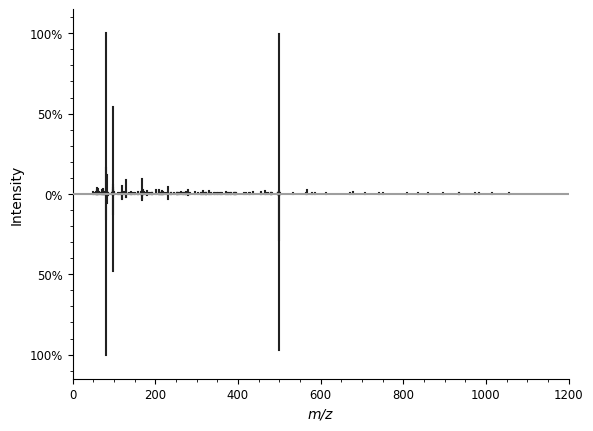

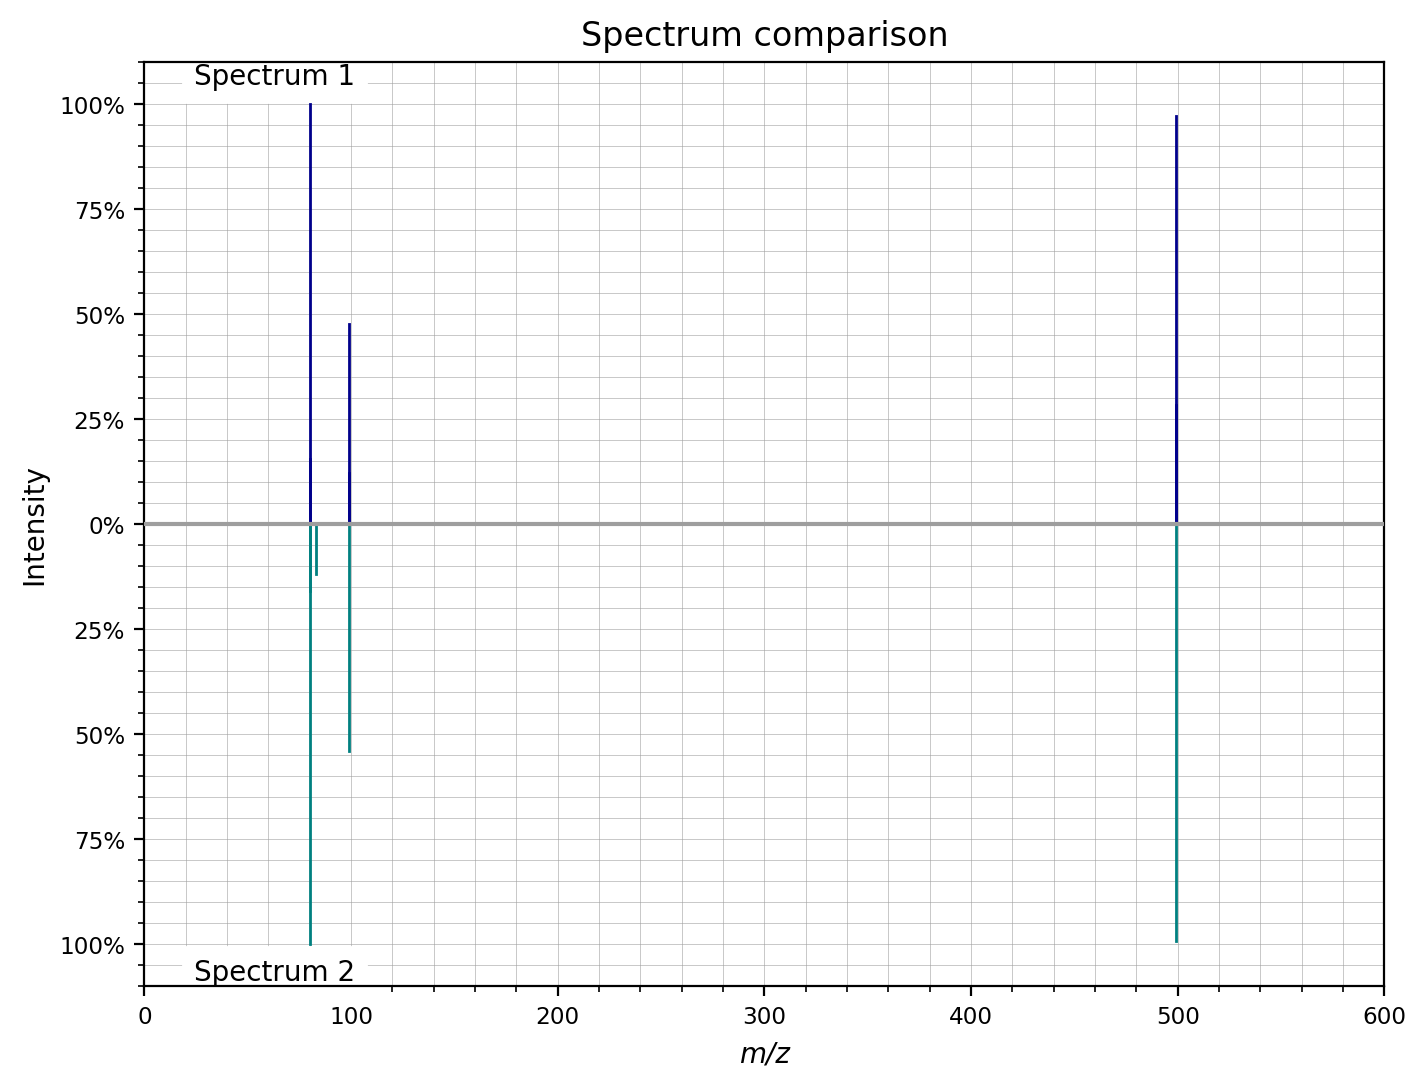

In [100]:
# Example usage
# target_mz = 144.04558
target_mz = 498.93015 #y
# target_mz = 398.93625 #n
# target_mz = 212.11842
# q_filepath= "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/NOV22/B1-10-MSMS-neg_I5.mzML"
# q_filepath= "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/NOV22/B1-10-MSMS-neg_I4.mzML"
q_filepath= "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/NOV22/B1-10-MSMS-neg_I2.mzML"
# q_filepath= "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/NOV22/B1-10-MSMS-neg_I3.mzML"
# q_filepath = "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/NOV22/B1-10-MSMS-pos_I1.mzML"
# ref_filepath = "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/B1-10pool_MSMS_12032024/B1-10_REVEAL_TarMSMS_E502a_r2.mzML"
ref_filepath = "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/B1_10pool_MSMS_12112024/B1_10pool_MSMS_12112024/REVEAL_PFAS-TarMSMS.mzML"
# ref_filepath = "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/B1-10pool_MSMS_11272024/ENTACT508_pos-TarMSMS.mzML"

ms2_query = preprocess_spectra(q_filepath, target_mz, 40, tolerance=10)
ms2_ref = preprocess_spectra(ref_filepath, target_mz, 40, tolerance=10)

import pyopenms
# spectrum_similarity(ms2_query[0], ms2_ref[0], tolerance = 5.0, baseline = 10)
from pyopenms.plotting import mirror_plot_spectrum
mirror_plot_spectrum(ms2_query[0], ms2_ref[0])

def normalize_and_filter(spectrum, baseline):
    try:
        mz, intensity = spectrum.get_peaks()
    except AttributeError: 
        # mz, intensity = zip(*[(float(m), float(i)) for m, i in spectrum if isinstance(m, (int, float)) and isinstance(i, (int, float))])
        mz, intensity = zip(*spectrum)
        mz = np.array(mz)
        intensity = np.array(intensity)
    except:
        raise ValueError("Please provide a valid spectrum object.")
    
    intensity = np.round((intensity / max(intensity)) * 100, 1)
    indices = np.where(intensity >= baseline)
    return mz[indices], intensity[indices]


#function to get spectrum
def get_spectrum(spectrum):
    try:
        mz, intensity = spectrum.get_peaks()
    except AttributeError:
        mz, intensity = zip(*spectrum)
        mz = np.array(mz)
        intensity = np.array(intensity)
    return mz, intensity

reference = Spectrum(mz=normalize_and_filter(ms2_ref[0], baseline=10)[0], 
                     intensities = normalize_and_filter(ms2_ref[0], baseline=10)[1],
                     metadata={"inchikey": "reference.mzML"})   

query = Spectrum(mz=normalize_and_filter(ms2_query[0], baseline=10)[0], 
                 intensities = normalize_and_filter(ms2_query[0], baseline=10)[1])

print(f'reference spectrum: {reference.get("inchikey")}')

cosine_greedy = CosineGreedy(tolerance=0.005, mz_power=1.3, intensity_power=0.53)
score = cosine_greedy.pair(reference, query)

print(f"Cosine score is {score['score']:.2f} with {score['matches']} matched peaks")

reference.plot_against(query)

In [ ]:
#extract chemical meta information of the unique chemicals at level 2a and 2b 

#plot the number of reported chemicals by bloodexposome and worldexposome

#plot the nubm
